# ECE 469/569 Final Project -- Exploiting Vulnerabilities in Emotion Recognition for Health Monitoring Systems
by Zachary Perry, Manan Patel, Jaehwan Park, Jennifer Maranville

---


### Dataset -- RAVDESS Dataset
This portion of the RAVDESS dataset contains 1440 audio files made up of 60 trials from 24 different actors. Each audio file contains audio of one of the actors vocalizing statements with a particular emotion. These emotions include calm, happy, sad, angry, fearful, surprise, and disgust. Each emotion is captured twice with different levels of intensity.

For more information, please visit: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio


### Approach
We decided to create and train our own CNN model with this dataset for emotion classification via audio clips. Doing so involved data processing (of the audio files), training of our model, testing, and supporting the ability to give it an audio file and have it classify correctly.


### Attacks
To exploit our CNN and attack the emotion classification, we utilized two different, untargeted attacks: 
1. FGSM
2. PGD

The goal was to create adversarial audio examples and get the model to make the wrong prediction.

## Dependencies & Imports

In [15]:
# %pip install keras
# %pip install tensorflow
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install sklearn
# %pip install librosa
# %pip install soundfile
# %pip install pyaudio
# get the data from https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio, store into ./input folder.

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
import soundfile as sf
warnings.filterwarnings('ignore')

## Data Processing
To properly train and test our model, we need to ensure our dataset is properly processed.

In order to accomplish this, we load all of the audio files, extract the mel spectrogram (normalized, in decibels, perfect format for audio classification), and create our feature/labels.

We also provide means to augment the audio files to train our model with and make it more robust

In [17]:
"""
Function to augment the audio by pitch shifting and time stretching.
The augmentations aren't super strong, but they are enough to help the model generalize better.
Args:
    y: audio time series
    sr: sample rate
Returns:
    augmented: augmented audio time series
"""
def augment_audio(y, sr):
    augmented = y.copy()
    
    # Randomly apply pitch shifting
    if np.random.random() > 0.7:
        augmented = librosa.effects.pitch_shift(augmented, sr=sr, n_steps=np.random.uniform(-1, 1))
    
    # Randomly apply time stretching
    if np.random.random() > 0.7:
        augmented = librosa.effects.time_stretch(augmented, rate=np.random.uniform(0.9, 1.1))
    
    return augmented

"""
Function to load and process the audio files. It will load the audio file, extract the mel spectrogram, convert it to decibels, and normalize it.
Args:
    file_path: The file path of the audio file
    duration: The duration of the audio file to load
    sr: The sample rate
    augment: Whether to augment the audio or not (additional data added)
Returns:
    normalized_mel_spectrogram_decibels: The normalized mel spectrogram in decibels
"""
def load_and_process_audio(file_path, duration=3, sr=22050, augment=False):
    y, sr = librosa.load(file_path, duration=duration, sr=sr)
    
    # Call the augment_audio function to augment the audio
    if augment:
        y = augment_audio(y, sr)
    
    # Pad the audio file if it is less than the duration
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    else:
        y = y[:sr * duration]
    
    # Extract the mel spectrogram, convert to decibels, and normalize
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_spectrogram_decibels = librosa.power_to_db(spectrogram, ref=np.max)
    normalized_mel_spectrogram_decibels = (mel_spectrogram_decibels - mel_spectrogram_decibels.mean()) / (mel_spectrogram_decibels.std() + 1e-8)
    
    # Commented out so that we aren't printing a bajillion spectrograms, but this will show the mel spectrogram for each audio file to ensure they are being processed correctly
    #visualize_mel_spectrogram(normalized_mel_spectrogram_decibels, file_path)

    return normalized_mel_spectrogram_decibels

"""
Function to plot and show the mel_spectrogram for the given audio file.
CURRENTLY -> not called since call to this is commented out.
Args:
    mel_spectrogram: The mel spectrogram to visualize
    file_path: The file path of the audio file
    sr: The sample rate
    hop_length: The hop length
Returns:
    None
"""
def visualize_mel_spectrogram(mel_spectrogram, file_path, sr=22050, hop_length=512):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram for Audio File: ' + file_path)
    plt.show()

"""
Function to create the dataset from the audio files. It will load the audio files, extract the mel spectrogram, 
and create the dataset. This is what is used to train & test the model.
Args:
    None
Returns:
    features: The mel spectrograms
    labels: The emotion codes
    file_paths: The file paths of the audio files
"""
def create_dataset():
    features = []
    labels = []
    file_paths = []
   
   # Walk through all the files in the data directory
    for root, dirs, files in os.walk('./data/'):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                
                # Gets the emotion code from the file name
                # Then, loads and processes the audio file, along with augmenting it
                emotion_code = int(file.split('-')[2])
                mel_spectrogram = load_and_process_audio(file_path)
                augmented_mel_spectrogram = load_and_process_audio(file_path, augment=True)
                
                # Adds the mel spectrogram and emotion code to the features and labels arrays
                # Does the same for the augmented mel spectrogram
                features.append(mel_spectrogram)
                labels.append(emotion_code)
                features.append(augmented_mel_spectrogram)
                labels.append(emotion_code)

                # Adds the file path and augmented file path to the file paths array
                file_paths.append(file_path)
                file_paths.append(file_path + '_augmented')

    print(f"\nSuccessfully processed all files.")
    
    # Converts the features and labels arrays to numpy arrays, and returns them along with the file paths array
    return np.array(features, dtype=np.float32), np.array(labels), file_paths

## CNN Model
Build our own CNN to classify these emotions based on audio.

It contains 2 convolutional blocks, each with a convolutional layer, max pooling layer, and dropout layer.

The last layer is a dense layer to flatten and combine the features, followed by a dropout layer and a dense layer with softmax activation.

In [18]:
"""
Function to build the CNN model using tensorflow. 
Args:
    input_shape: The shape of the input data
    num_classes: The number of classes
Returns:
    model: The CNN model
"""
def build_CNN_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Reshape((*input_shape, 1)),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

## Creating Dataset, Model, & Splitting (Train, Test)
Processes and creates the dataset, which is then used to create the train/test split for the model.

The training/testing data split is 80%/20%. Additionally, we utilize a validation set with training, which is about 15% of the training data.

#### More Model Info
For the model, we also use the Adam Optimizer primarily for its adaptive learning rates, which have helped significantly in giving different weights to the different features in the audio. For example, recognizing higher, different pitch variations for happy/angry, lower frequency in sadness, etc. It also normalizes gradients, preventing some features from overshadowing others. 

We also use sparse_categorical_cross entropy for the loss function. Since the audio clips only contain a single emotion, have a distinct class, and all "emotion counts" are balanced, it becomes very useful in determining how accurate (or inaccurate) the model is.

In [19]:
# Create the dataset
features, labels, file_paths = create_dataset()

# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(40*'=')
print(f"Dataset Info:")
print(f"    Number of classes: {num_classes}")
print(f"    Feature shape: {features.shape}")
print(f"\nNumber of unique files: {len(set(file_paths))}")
print(40*'=')


Successfully processed all files.
Dataset Info:
    Number of classes: 8
    Feature shape: (2880, 128, 130)

Number of unique files: 2880


In [20]:
# Get the training and testing data
# 20% testing, 80% training
X_temp, X_test, y_temp, y_test, paths_temp, test_paths = train_test_split(
    features, labels_encoded, file_paths,
    test_size=0.2, 
    random_state=42, 
    stratify=labels_encoded
)

# Split the training data into training and validation data
# 15% validation, 85% training (which is 80% of the original data)
X_train, X_val, y_train, y_val, train_paths, val_paths= train_test_split(
    X_temp, y_temp, paths_temp,
    test_size=0.15,
    random_state=42,
    stratify=y_temp
)

# Create the CNN and compile it
# Using the Adam optimizer and sparse categorical crossentropy loss
input_shape = features[0].shape
model = build_CNN_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,408,584 (32.08 MB)

 Trainable params: 8,408,584 (32.08 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model using the training and validation data
# Using early stopping to prevent overfitting
# Using a batch size of 32 and 50 training epochs
# Load the model if one was saved previously. Otherwise, create and train a new one.
# NOTE: This was done so that we could just reload our 85% testing accuracy model instead of retraining
if os.path.exists('model.h5'):
    model = tf.keras.models.load_model('model.h5')
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(60*'=')
    print(f"Testing Info:")
    print(f"    Final test accuracy: {test_accuracy:.4f}")
    print(f"    Final test loss: {test_loss:.4f}")
    print(60*'=')

else:
    # Train the model using the training and validation data
    training_and_validation = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    # Test the model using the testing data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Save the model if the testing accuracy is greater than 0.85
    if test_accuracy > 0.85:
        model.save('model.h5')

    # Output the training and testing information
    print(60*'=')
    print(f"Training Info:")
    print(f"    Training loss: {training_and_validation.history['loss'][-1]:.4f}")
    print(f"    Training accuracy: {training_and_validation.history['accuracy'][-1]:.4f}")
    print(f"    Validation loss: {training_and_validation.history['val_loss'][-1]:.4f}")
    print(f"    Validation accuracy: {training_and_validation.history['val_accuracy'][-1]:.4f}")
    print(f"Testing Info:")
    print(f"    Final test accuracy: {test_accuracy:.4f}")
    print(f"    Final test loss: {test_loss:.4f}")
    print(60*'=')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8709 - loss: 0.4863
Testing Info:
    Final test accuracy: 0.8385
    Final test loss: 0.5835


In [22]:
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Load the saved model (if needed) and recompile it
# NOTE: The warning displayed does not affect the model performance
model = tf.keras.models.load_model('model.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Get a random index from the testing data to grab a random sample to use for prediction
# NOTE: This will ensure it tests with a file that has not been augmented so that you can actually listen to it 
while 1: 
    random_sample_index = np.random.randint(0, len(X_test));
    random_sample = X_test[random_sample_index:random_sample_index+1] 
    if '_augmented' not in test_paths[random_sample_index]:
        break

# This code will allow you to test with an augmented file
# random_sample_index = np.random.randint(0, len(X_test));
# random_sample = X_test[random_sample_index:random_sample_index+1] 

# Predict the class of the random sample using the model
y_pred = model.predict(random_sample)
encoded_pred = np.argmax(y_pred)
encoded_true = y_test[random_sample_index]
y_pred_label = label_encoder.inverse_transform([np.argmax(y_pred)])[0]
y_true_label = label_encoder.inverse_transform([y_test[random_sample_index]])[0]

print(f"True label: {y_true_label} -- {emotions[encoded_true]}")
print(f"Predicted label: {y_pred_label} -- {emotions[encoded_pred]}")
print(f"File path: {test_paths[random_sample_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
True label: 7 -- disgust
Predicted label: 7 -- disgust
File path: ./data/Actor_02/03-01-07-01-01-01-02.wav


## FGSM Attack
This code will perform the Fast Gradient Sign Method (FGSM) attack on the model. What this does is it takes the input audio file and perturbs it slightly to change the prediction of the model. The goal is to create an adversarial example that sounds the same but is classified differently

Our approach involves creating a subtle perturbation to the mel spectrogram, then converting it back to audio. This will allow us to create an adversarial audio file that sounds similar to the original. We can then give this audio file to the model to see if it changes the prediction

In [23]:
# Load the model
# Get the test file path
model = tf.keras.models.load_model('model.h5')
file_path = test_paths[random_sample_index]
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

"""
Function to create the mel spectrogram for the audio file. It will create the mel spectrogram, convert it to decibels, and normalize it.
Args:
    audio: the audio file to create the mel spectrogram for
    sr: sample rate
Returns:
    mel_spectrogram_decibels: the mel spectrogram in decibels
"""
def create_spectrogram(audio, sr=22050):
    # Create the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=128,
        n_fft=2048,
        hop_length=512
    )
    
    # Convert to decibels & normalize
    mel_spectrogram_decibels = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram_decibels = (mel_spectrogram_decibels - mel_spectrogram_decibels.mean()) / (mel_spectrogram_decibels.std() + 1e-8)

    return mel_spectrogram_decibels

"""
Function to perform the Fast Gradient Sign Method (FGSM) to create an adversarial example. 
It will create the adversarial example by adding a perturbation to the original audio.
Args:
    model: the trained model
    sample: the mel spectrogram of the sample
    true_label: the true label of the sample
    epsilon: epsilon value
Returns:
    adversarial_example: the adversarial example
    sign_gradient: the signed gradient
"""
def fgsm(model, sample, true_label, epsilon=0.001):
    # Expand the dimensions of the sample
    # Then convert to tensor and get the true label tensor
    # NOTE: The true label is subtracted by 1 because the model and the label encoder are 0-indexed
        # For example, 8 = surprised, but the model and label encoder will have it as 7
    input = np.expand_dims(np.expand_dims(sample, 0), -1)
    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor([true_label-1], dtype=tf.int32)
    
    # Use GradientTape to get the gradients
    # Then use sparse_categorical_crossentropy to get the loss
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label_tensor, predictions)
    
    # Get gradients
    # Get the sign of the gradients
    gradients = tape.gradient(loss, input_tensor)
    sign_gradient = tf.sign(gradients)
    
    # Create adversarial example by adding perturbation
    adversarial_example = input_tensor + epsilon * sign_gradient
    
    # Return the adversarial example and the signed gradient
    return adversarial_example.numpy()[0, :, :, 0], sign_gradient.numpy()[0, :, :, 0]

"""
Function to add a perturbation to the original audio to create an adversarial audio.
This will allow us to actual listen to the adversarial audio.
Args:
    original_audio: the original audio 
    perturbation: the perturbation to add to the original audio 
    epsilon: epsilon value
    sr: sample rate
Returns:
    adversarial_audio: the adversarial audio
"""
def create_adversarial_audio(original_audio, perturbation, epsilon=0.001, sr=22050):
    # Create time-domain perturbation matching original audio length
    # It will use the Griffin-Lim algorithm to convert the mel spectrogram back to audio
    time_perturbation = librosa.griffinlim(
        np.abs(perturbation),
        n_iter=32,
        hop_length=512
    )
    
    # Then, ensure that the perturbation is the same length as the original audio
    # If the perturbation is longer, then pad it with zeros
    if len(time_perturbation) > len(original_audio):
        time_perturbation = time_perturbation[:len(original_audio)]
    else:
        time_perturbation = np.pad(time_perturbation, (0, len(original_audio) - len(time_perturbation)))
    
    # Normalize the perturbation and add it to the original audio
    # Make sure the adversarial audio is normalized
    # Then, scale it back to the original audio's max value & apply a subtle high-pass filter to remove noise
    time_perturbation = librosa.util.normalize(time_perturbation)
    adversarial_audio = original_audio + epsilon * time_perturbation
    adversarial_audio = librosa.util.normalize(adversarial_audio)
    adversarial_audio = adversarial_audio * np.max(np.abs(original_audio))
    adversarial_audio = librosa.effects.preemphasis(adversarial_audio)
    
    return adversarial_audio

"""
Function to plot the mel spectrogram for the original audio, the perturbation, and the adversarial audio.
Args:
    mel_spectrogram: the mel spectrogram of the original audio
    perturbation: the perturbation
    adversarial_audio: the adversarial audio
    sr: sample rate
    emotion_labels: the emotion labels
    original_class: the original class
    adv_class: the adversarial class
Returns:
    None
"""
def plot_spectrogram(mel_spectrogram, perturbation, adversarial_audio, sr, emotion_labels, original_class, adv_class):
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(mel_spectrogram)
    plt.title(f'Original\nClass: {emotion_labels[original_class]}')
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(perturbation)
    plt.title('Perturbation\n')
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(create_spectrogram(adversarial_audio, sr))
    plt.title(f'Adversarial\nClass: {emotion_labels[adv_class]}')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


Original Probabilities:
    neutral: 0.011
    calm: 0.028
    happy: 0.144
    sad: 0.293
    angry: 0.115
    fearful: 0.037
    disgust: 0.294
    surprised: 0.079

Adversarial Probabilities:
    neutral: 0.000
    calm: 0.000
    happy: 0.000
    sad: 0.000
    angry: 0.019
    fearful: 0.981
    disgust: 0.000
    surprised: 0.000


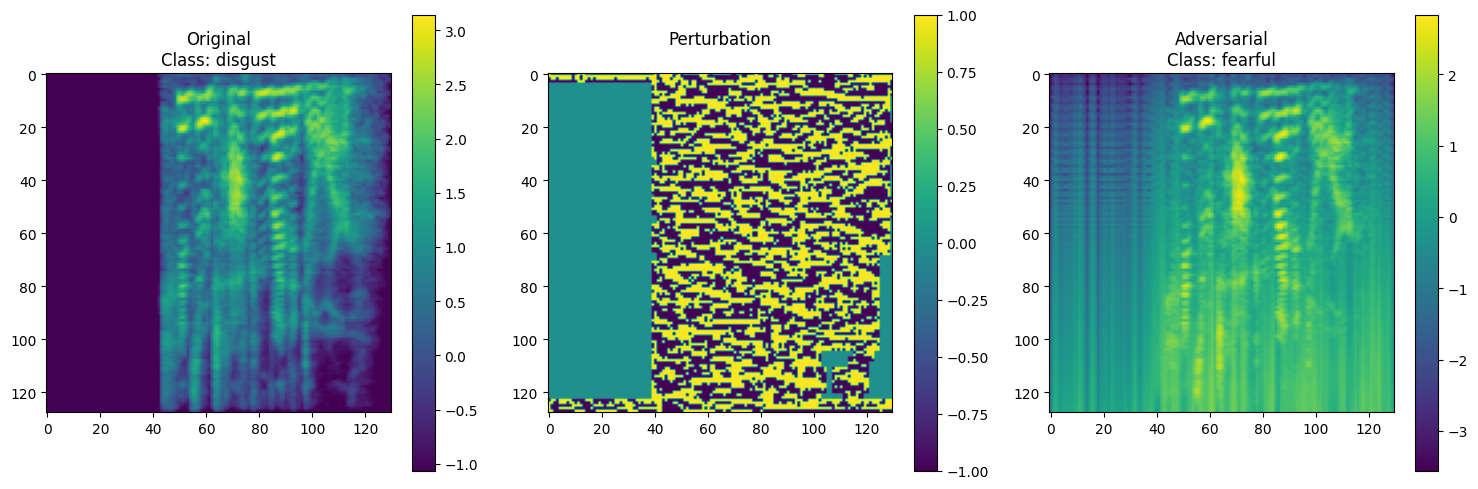

In [ ]:
##### Now we can create the adversarial example and test it #####
# Create the output directory for the adversarial audio files
os.makedirs('adversarial_outputs', exist_ok=True)

# Load original audio and create mel spectrogram
# Ge thte emotion label from the file name (RAVDESS format)
original_audio, sr = librosa.load(file_path, sr=22050, duration=3)
mel_spectrogram = create_spectrogram(original_audio, sr)
emotion_label = int(os.path.basename(file_path).split('-')[2])

# Use FGSM to create adversarial example
# Then, create the actual adversarial audio that we can listen to using the perturbation
# NOTE: The epsilon value needed to be adjusted to 0.08 to get consistent results
# NOTE: However, epsilon values did vary depending on the audio file read in
adversarial_spec, perturbation = fgsm(model, mel_spectrogram, emotion_label, epsilon=0.08)
adversarial_audio = create_adversarial_audio(original_audio, perturbation, epsilon=0.08)

# Get the original and adversarial input for the model
original_input = np.expand_dims(np.expand_dims(mel_spectrogram, 0), -1)
adversarial_input = np.expand_dims(
    np.expand_dims(
        create_spectrogram(adversarial_audio, sr), 0), -1)

# Predict the original and adversarial input, as well as the classes themselves
original_pred = model.predict(original_input, verbose=0)
adversarial_pred = model.predict(adversarial_input, verbose=0)
original_class = np.argmax(original_pred[0])
adversarial_class = np.argmax(adversarial_pred[0])

# Print out the original and adversarial probabilities for each class.
print("\nOriginal Probabilities:")
for emotion, prob in zip(emotion_labels, original_pred[0]):
    print(f"    {emotion}: {prob:.3f}")
print("\nAdversarial Probabilities:")
for emotion, prob in zip(emotion_labels, adversarial_pred[0]):
    print(f"    {emotion}: {prob:.3f}")

# Plot the mel spectrogram for the original audio, the perturbation, and the adversarial audio
plot_spectrogram(mel_spectrogram, perturbation, adversarial_audio, sr, emotion_labels, original_class, adversarial_class)

# Save the audio files
sf.write('adversarial_outputs/original_FGSM.wav', original_audio, sr)
sf.write('adversarial_outputs/adversarial_FGSM.wav', adversarial_audio, sr)

## PGD Attack Attempt
This code will perform the untargeted Projected Gradient Descent (PGD) attack on the model. This is very similar to FGSM, except it takes multiple, iterative steps and projects back to an epsilon ball around the original input. This should result in an adversarial audio clip that is very similar to the original clip. 

Our approach here is very similar to the FGSM approach, except we call our PGD attack instead

In [ ]:
# Reload the model (if needed)
# Also get the test file path (again, if needed)
model = tf.keras.models.load_model('model.h5')
file_path = test_paths[random_sample_index]

"""
Function to perform the Projected Gradient Descent (PGD) attack to create an adversarial example.
Args:
    model: the trained model
    sample: the mel spectrogram of the sample
    true_label: the true label of the sample
    epsilon: epsilon value
    steps: number of steps to perform
    step_size: step size to use
Returns:
    adversarial_example: the adversarial example
    perturbation: the perturbation
"""
def pgd(model, sample, true_label, epsilon=0.0001, steps=100, step_size=0.001):
    # Expand the dimensions of the sample
    # Then convert to tensor and get the true label tensor
    # NOTE: The true label is subtracted by 1 because the model and the label encoder are 0-indexed
        # For example, 8 = surprised, but the model and label encoder will have it as 7
    input = np.expand_dims(np.expand_dims(sample, 0), -1)
    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor([true_label-1], dtype=tf.int32)
    
    # Create noise and add it to the input tensor
    # This will help with the projection step later
    noise = tf.random.uniform(input_tensor.shape, -epsilon, epsilon)
    adversarial_example = input_tensor + noise
    
    # Now, we use the steps to perform the PGD attack
    for step in range(steps):
        with tf.GradientTape() as tape:
            
            # Get the predictions and calculate the loss
            tape.watch(adversarial_example)
            predictions = model(adversarial_example)
            loss = -tf.keras.losses.sparse_categorical_crossentropy(
                label_tensor, predictions)
        
        # Get the gradients and the signed gradients
        gradients = tape.gradient(loss, adversarial_example)
        signed_gradient = tf.sign(gradients)
        
        # Update the input tensor with the signed gradient 
        adversarial_example = adversarial_example + step_size * signed_gradient
        
        # Project back to epsilon ball
        perturbation = tf.clip_by_value(adversarial_example - input, -epsilon, epsilon)
        adversarial_example = input + perturbation
        adversarial_example = tf.clip_by_value(adversarial_example, -1, 1)
    
    # Return the adversarial example and the perturbation
    return adversarial_example.numpy()[0, :, :, 0], perturbation.numpy()[0, :, :, 0]


Original Probabilities:
    neutral: 0.011
    calm: 0.028
    happy: 0.144
    sad: 0.293
    angry: 0.115
    fearful: 0.037
    disgust: 0.294
    surprised: 0.079

Adversarial Probabilities:
    neutral: 0.000
    calm: 0.000
    happy: 0.000
    sad: 0.000
    angry: 0.950
    fearful: 0.023
    disgust: 0.026
    surprised: 0.001


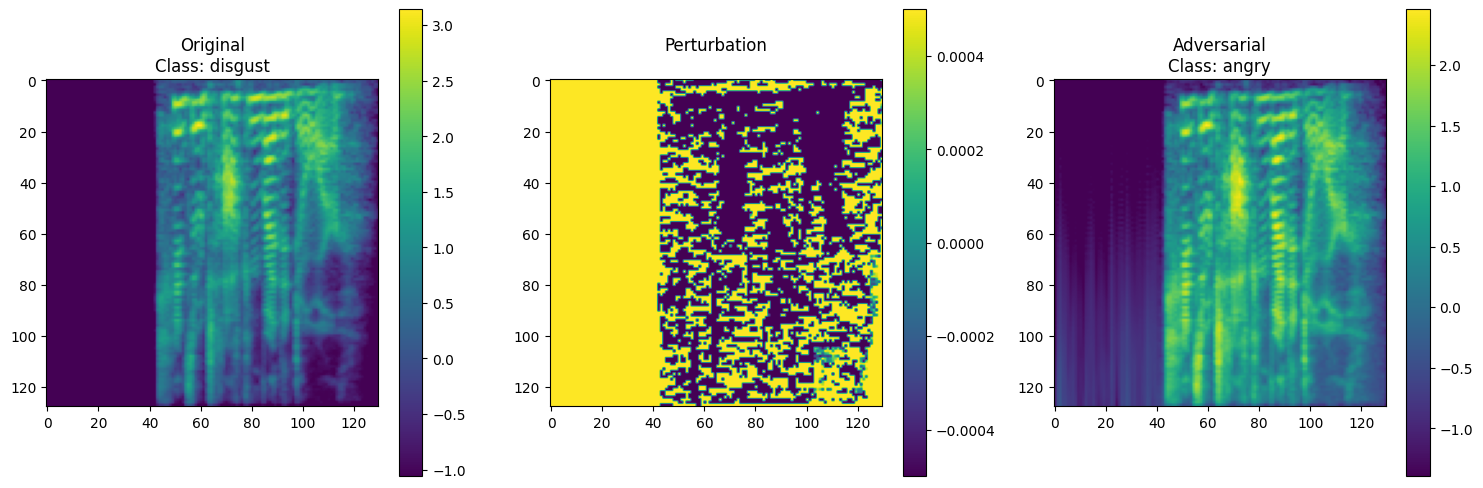

In [ ]:

# Create output directory (if it doesn't exist already)
os.makedirs('adversarial_outputs', exist_ok=True)

original_audio, sr = librosa.load(file_path, sr=22050, duration=3)
mel_spectrogram = create_spectrogram(original_audio, sr)
    
# Get emotion label from filename
emotion_label = int(os.path.basename(file_path).split('-')[2])
    
# Use PGD to create adversarial example & also create adversarial audio to listen to
# NOTE: The epsilon value needed to be adjusted to 0.0005 to get consistent results
# NOTE: However, epsilon values did vary depending on the audio file read in
adversarial_spec, perturbation = pgd(model, mel_spectrogram, emotion_label, epsilon=0.0005, steps=150, step_size=0.001)
adversarial_audio = create_adversarial_audio(original_audio, perturbation, epsilon=0.0005)

# Get original and adversarial input for model
original_input = np.expand_dims(np.expand_dims(mel_spectrogram, 0), -1)
adversarial_input = np.expand_dims(np.expand_dims(create_spectrogram(adversarial_audio, sr), 0), -1)

# Predict original and adversarial input, as well as the classes themselves
original_pred = model.predict(original_input, verbose=0)
adv_pred = model.predict(adversarial_input, verbose=0)
original_class = np.argmax(original_pred[0])
adv_class = np.argmax(adv_pred[0])

# Print out original and adversarial probabilities for each class
print("\nOriginal Probabilities:")
for emotion, prob in zip(emotion_labels, original_pred[0]):
    print(f"    {emotion}: {prob:.3f}")

print("\nAdversarial Probabilities:")
for emotion, prob in zip(emotion_labels, adv_pred[0]):
    print(f"    {emotion}: {prob:.3f}")

# Plot mel spectrogram for original audio, perturbation, and adversarial audio
plot_spectrogram(mel_spectrogram, perturbation, adversarial_audio, sr, emotion_labels, original_class, adv_class)

# Save audio files
sf.write('adversarial_outputs/original_PGD.wav', original_audio, sr)
sf.write('adversarial_outputs/adversarial_PGD.wav', adversarial_audio, sr)


## Results
Plot the final results, comparing the original audio, FGSM, and PGD audio to view the differences

Overall, we were able to successfully apply these attack to get the model to mis-predict. However, this did require some tuning (epsilon values did vary depending on the example).

In [27]:
def plot_audio_waveform(original_audio, fsgm_audio, pgd_audio, file_path):
    plt.figure(figsize=(15, 10))
    plt.subplot(4, 1, 1)
    plt.plot(original_audio)
    plt.title('Original Audio' + file_path)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    # Plot the FGSM audio
    plt.subplot(4, 1, 2)
    plt.plot(fsgm_audio)
    plt.title('Adversarial FGSM Audio')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    # Plot PGD audio
    plt.subplot(4, 1, 3)
    plt.plot(pgd_audio)
    plt.title('Adversarial PGD Audio')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

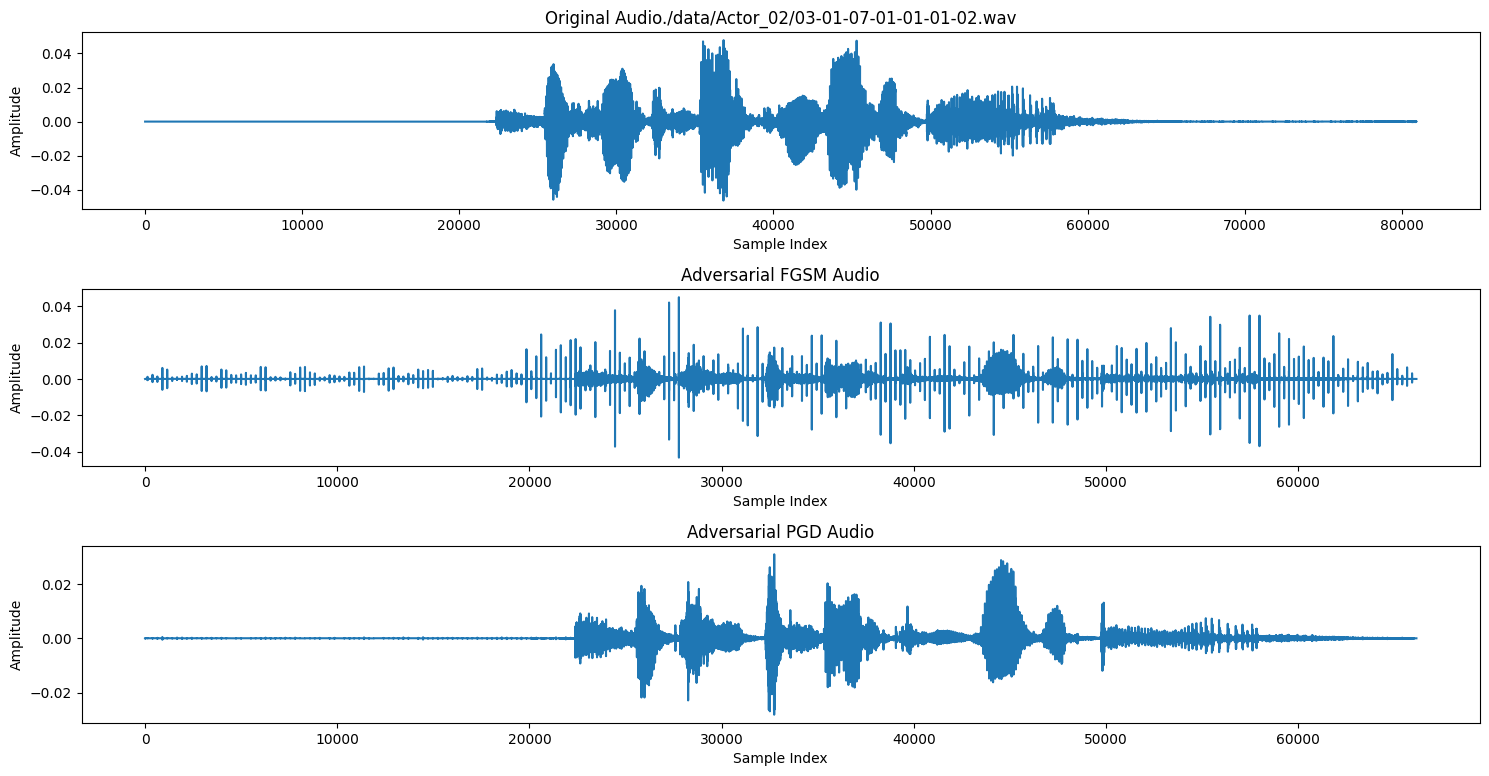

In [28]:
original_audio, _ = librosa.load(file_path, sr=22050)
fgsm_audio, _ = librosa.load('adversarial_outputs/adversarial_FGSM.wav', sr=22050)
pgd_audio, _ = librosa.load('adversarial_outputs/adversarial_PGD.wav', sr=22050)

plot_audio_waveform(original_audio, fgsm_audio, pgd_audio, file_path)